In [1]:
import xarray as xr
import numpy as np
import re
import pandas as pd
from osgeo import gdal, ogr, osr
from rasterio import warp
from datacube.utils.geometry import assign_crs
from datacube.utils.geometry import GeoBox
from odc.algo import xr_reproject
from matplotlib import pyplot as plt
from scipy import ndimage
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import boto3
import awswrangler as wr

from datacube.utils.dask import start_local_dask

In [ ]:
client = start_local_dask(n_workers=1, threads_per_worker=60, memory_limit='478GB')
client

In [220]:
def load_lidar_tif(fname, res_tgt, med_filter=False):
    """
        load drone imagery with given file name and resolution
        input:
            fname: file name of lidar raster
            res_tgt: resample resolution of output, type: tuple, e.g. res_tgt=(1, 1)
            med_filter: if apply median filter
        output:
            xarray.DataSet of imagery
        
    """
    lidar_data = xr.open_rasterio(fname, parse_coordinates=True, chunks={'band': 1, 'x': -1, 'y': -1})
    # don't know why < 40, only copy from the old code
    lidar_data = lidar_data.where((lidar_data > 0) & (lidar_data < 40), 0)
    if med_filter:
        lidar_data.data = lidar_data.data.map_blocks(ndimage.median_filter, (1, 3, 3), None, None, "nearest")
    lidar_data = assign_crs(lidar_data)
    affine, width, height = warp.calculate_default_transform(lidar_data.crs, 'EPSG:3577', lidar_data.shape[1], lidar_data.shape[2],
                                             *lidar_data.geobox.extent.boundingbox)
    tgt_affine, tgt_width, tgt_height = warp.aligned_target(affine, width, height, res_tgt)
    lidar_geobox = GeoBox(tgt_width, tgt_height, tgt_affine, 'EPSG:3577')
    lidar_tgt = xr_reproject(lidar_data, lidar_geobox, resampling= 'bilinear' )
    return (lidar_tgt > 0).astype('float16')

def generate_mangroves_mask(shape_file, data_shape, orig_coords, resolution):
    """
        creak mask without oceans
        input:
            shape_file: the shape file of Australia coastline
            data_shape: the shape of loaded data to be masked upon
            orig_coords: the origin of the image for gdal to decide the transform
            resolution: pixel size with signs, e.g., (30, -30) for C3 and (25, -25) for C2
        output:
            a numpy array of mask, where valid pixels = 1
    """
    source_ds = ogr.Open(shape_file)
    source_layer = source_ds.GetLayer()

    yt, xt = data_shape
    xres = resolution[0]
    yres = resolution[1]
    no_data = 0

    xcoord, ycoord = orig_coords
    geotransform = (xcoord - (xres*0.5), xres, 0, ycoord - (yres*0.5), 0, yres)

    target_ds = gdal.GetDriverByName('MEM').Create('', xt, yt, gdal.GDT_Byte)
    target_ds.SetGeoTransform(geotransform)
    albers = osr.SpatialReference()
    albers.ImportFromEPSG(3577)
    target_ds.SetProjection(albers.ExportToWkt())
    band = target_ds.GetRasterBand(1)
    band.SetNoDataValue(no_data)

    gdal.RasterizeLayer(target_ds, [1], source_layer, burn_values=[1])
    return band.ReadAsArray()

def lidar_to_pcc_perc(lidar_data, res=(30,30)):
    reduced = lidar_data.loc[dict(x=slice(lidar_data.x[np.where((lidar_data.x - 0.5) % res[0] == 0)].min().data-0.5, 
                      lidar_data.x[np.where((lidar_data.x + 0.5) % res[0] == 0)].max().data+0.5),
                 y=slice(lidar_data.y[np.where((lidar_data.y + 0.5) % res[1] == 0)].max().data+0.5, 
                      lidar_data.y[np.where((lidar_data.y - 0.5) % res[1] == 0)].min().data-0.5))]
    reduced = (reduced.coarsen(y=30, x=30).sum() / 30**2 * 100).astype('float32')
    return reduced

In [185]:
session = boto3.Session(profile_name='dev')
mangroves_bucket = "s3://dea-public-data-dev/test/mangroves-lidar/"
fc_bucket = "s3://dea-public-data-dev/test/fc-percentile/"
mangroves_tile_list = np.array([(34, 17),
                       (38, 40),
                       (48, 27),
                       (45, 16),
                       (45, 15),
                       (8, 31),
                       (49, 24),
                    ])
mangroves_shape_file = "maximum_extent_of_mangroves_Apr2019.shp"

In [ ]:
mangroves_lidar_file = wr.s3.list_objects(mangroves_bucket, ignore_suffix=["_hgtthresd.tif", "_med.tif", "_MangCanopyMask.tif", "_subset_mskd.tif"], 
                                          boto3_session=session)
input_file_list = []
for l_file in mangroves_lidar_file:
    if 'QLD_LiDAR_CHM' in l_file:
        continue
    print(l_file)
    for d in (re.findall(r'\d{4}(?=/)', l_file)):
        if int(d) >= 1987 and int(d) < 2020:
            input_file_list += [(l_file, int(d))]

In [219]:
fc_x_dirs = wr.s3.list_directories(fc_bucket, boto3_session=session)
fc_file_dirs = []
for x_idx in fc_x_dirs:
    if int(x_idx.split('/')[-2].strip('x')) in mangroves_tile_list[:,0]:
        fc_file_dirs += wr.s3.list_directories(x_idx, boto3_session=session)

In [ ]:
results = None
for l_file, l_year in input_file_list:
    print("process", l_file, l_year)
    if "Adelaide" in l_file or "Exmouth" in l_file:
        med_filter = False
    else:
        med_filter = True
    lidar_data = load_lidar_tif(l_file, (1, 1), med_filter)
    reduced = lidar_to_pcc_perc(lidar_data)
    fc_intersect_list = []
    for f_dir in fc_file_dirs:
        non_empty_list = wr.s3.list_objects(f_dir+ str(l_year) + "--P1Y", boto3_session=session, suffix=['_pv_pc_10.tif'])
        fcp_data = xr.open_rasterio(non_empty_list[0], chunks={'x':-1, 'y':-1})
        if (lidar_data.geobox.extent.intersects(fcp_data.geobox.extent)):
            print(non_empty_list)
            fcp_data = fcp_data.loc[dict(x=slice(reduced.x.min().data-15, 
                          reduced.x.max().data+15),
                         y=slice(reduced.y.max().data+15, 
                          reduced.y.min().data-15))]
            fc_intersect_list += [fcp_data]
    reduced.load()
    for fcp_data in fc_intersect_list:
        fcp_data.load()
        mangroves_mask = generate_mangroves_mask(mangroves_shape_file, fcp_data.shape[1:], (fcp_data.x.min(), fcp_data.y.max()), (30, -30))
        combined_data = np.concatenate([fcp_data.where((fcp_data < 255) & (reduced > 0) & mangroves_mask).data.reshape(1, -1), 
           reduced.where((fcp_data < 255) & (reduced > 0) & mangroves_mask).data.reshape(1, -1)])
        combined_data = combined_data[:, ~np.isnan(combined_data).any(axis=0)]
        if results is None:
            results = combined_data
        else:
            results = np.hstack([results, combined_data])
        print(results.shape)
results = pd.DataFrame(data=results.T, columns=["pv_pc_10", "pcc"])
results.to_csv("mangroves_fcp_thresholding_input.csv", index=None)

In [222]:
results = pd.read_csv("mangroves_fcp_thresholding_input.csv")

<AxesSubplot:xlabel='pv_pc_10', ylabel='pcc'>

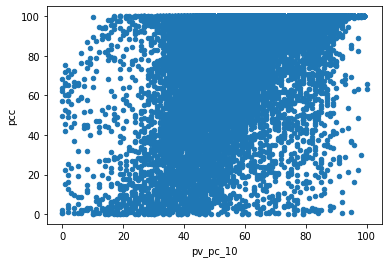

In [223]:
results.plot(x="pv_pc_10", y="pcc", kind="scatter")

In [287]:
binned = None
for i in range(100):
    idx = np.random.uniform(0, results.shape[0], results.shape[0] // 2 ).astype('int')
    if binned is None:
        binned = results.iloc[idx].groupby("pv_pc_10").agg({"pcc": ["mean", "std"]})["pcc"]
    else:
        binned += results.iloc[idx].groupby("pv_pc_10").agg({"pcc": ["mean", "std"]})["pcc"]
binned = binned.dropna() / 100

In [288]:
res_score = 0
for count_t in range(20, 150, 1):
    trimmed = binned[(results.groupby('pv_pc_10').count().loc[binned.index.to_numpy()] > count_t).to_numpy()]
    model = Pipeline([('poly', PolynomialFeatures(degree=3)), ('linear', LinearRegression(fit_intercept=False))])
    model.fit(trimmed.index.to_numpy().reshape(-1, 1), trimmed["mean"].to_numpy().reshape(-1, 1))
    rsq = model.score(trimmed.index.to_numpy().reshape(-1, 1), trimmed["mean"].to_numpy().reshape(-1, 1))
    print('r sq = ', rsq, count_t)
    if rsq > res_score:
        res_score = rsq
    else:
        break

r sq =  0.9514774048321663 20
r sq =  0.9702424255074099 21
r sq =  0.9722727640822696 22
r sq =  0.9717117127162416 23


Text(0, 0.5, 'pcc%')

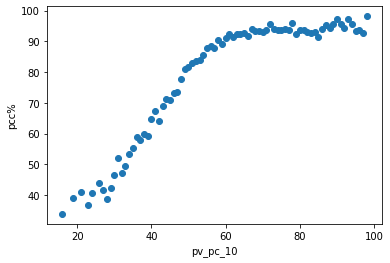

In [289]:
plt.plot(trimmed.index.to_numpy(), trimmed["mean"], "o")
plt.xlabel("pv_pc_10")
plt.ylabel("pcc%")

In [290]:
pvs = np.arange(0, 100, 1)
pccs = model.predict(pvs.reshape(-1, 1))

Text(0.5, 1.0, 'pv 10th percentile vs pcc%')

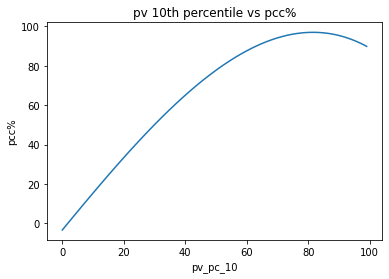

In [291]:
plt.plot(pvs, pccs)
plt.xlabel("pv_pc_10")
plt.ylabel("pcc%")
plt.title("pv 10th percentile vs pcc%")

In [292]:
pcc_cats = (20, 50, 80)
pv_threshold = ()
for i in pcc_cats:
    pv_threshold += (np.where(pccs >= i)[0][0], )

In [284]:
pv_threshold

(12, 30, 53)